In [1]:
#from google.colab import drive



In [2]:
#drive.mount('/content/drive')

Read CSV files and Add time stamps

In [3]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd
import re # search in an string
import seaborn as sns
plt.style.use('ggplot')


In [4]:
def read_data_file(file_path):
    num_data_lines = 22341
    num_skip_lines = 6
    num_iterations = 100
    initial_skip = 5
    data_array = np.zeros((num_iterations, num_data_lines))
    
    with open(file_path, 'r') as file:
        # Skip the initial lines
        for _ in range(initial_skip):
            next(file)
        
        for i in range(num_iterations):
            for j in range(num_data_lines):
                line = file.readline().strip()
                # Convert line to float or int depending on your data
                data_array[i, j] = float(line)  # Adjust this according to your data type
            
            # Skip lines only if it's not the last iteration
            if i < num_iterations - 1:
                for _ in range(num_skip_lines):
                    next(file)
    
    return data_array

In [5]:
def load_csv(file_path):
    all_snapshots = []
    lines_per_snapshot = 22341 #number of collocations/sensors in a single snapshot
    lines_of_garbage = 6
    lines_per_section = lines_per_snapshot + lines_of_garbage
    column_names = ['p', 'c', 'w', 'k', 'u', 'v', 'x', 'y']
    snapshot_number = 0
    for chunk in pd.read_csv(file_path,
                             chunksize=lines_per_section,
                             skip_blank_lines=False,
                             names=column_names,
                             delimiter=','):
        snapshot_number += 1
        chunk['snapshot'] = None
        data_lines = chunk.iloc[lines_of_garbage:].copy()
        if (len(data_lines)==0):break
        print(f"Loading snapshot {snapshot_number}/100, Length: {len(data_lines)}", end='\r', flush=True)# snap/100
        data_lines['t'] = snapshot_number
        all_snapshots.append(data_lines)
    data = pd.concat(all_snapshots, ignore_index=True)

    # data cleaning
    data['c'] = pd.to_numeric(data['c'], errors='coerce')
    data.loc[data['c'] < 0, 'c'] = 0
    data['p'] = pd.to_numeric(data['p'], errors='coerce')
    data['w'] = pd.to_numeric(data['w'], errors='coerce')
    data['k'] = pd.to_numeric(data['k'], errors='coerce')
    data['u'] = pd.to_numeric(data['u'], errors='coerce')
    data['v'] = pd.to_numeric(data['v'], errors='coerce')
    data['x'] = pd.to_numeric(data['x'], errors='coerce')
    data['y'] = pd.to_numeric(data['y'], errors='coerce')

    # add wind and leak_x, leak_y, leak_s to dataset
    [wind, leak_x, leak_y, leak_s] = determine_wind_and_leak(file_path)
    data['wind'] = wind
    data['leak_x'] = leak_x
    data['leak_y'] = leak_y
    data['leak_s'] = leak_s
    return data

In [6]:
def determine_wind_and_leak(file_path):
    leak_s = None
    wind = None
    leak_x = None
    leak_y = None
    file_name = file_path[-8:]

    radius = 40
    # determine free-stream ambient wind speed
    if re.search(r'l[hl]', file_name):
        wind = 6
    elif re.search(r'm[hl]', file_name):
        wind = 9
    elif re.search(r'h[hl]', file_name):
        wind = 12

    # determine leakage speed at the orifice
    if re.search(r'[lmh]l', file_name):
        leak_s = 0.5
    elif re.search(r'[lmh]h', file_name):
        leak_s = 1.0

    # determine leakage location
    if re.search(r'e[lmh][lh]', file_name):
        leak_x = radius
        leak_y = 0
    elif re.search(r'ne[lmh][lh]', file_name):
        leak_x = radius/np.sqrt(2)
        leak_y = radius/np.sqrt(2)
    elif re.search(r'n[lmh][lh]', file_name):
        leak_x = 0
        leak_y = radius
    elif re.search(r'nw[lmh][lh]', file_name):
        leak_x = -radius/np.sqrt(2)
        leak_y = radius/np.sqrt(2)
    elif re.search(r'w[lmh][lh]', file_name):
        leak_x = -radius
        leak_y = 0
    elif re.search(r'sw[lmh][lh]', file_name):
        leak_x = -radius/np.sqrt(2)
        leak_y = -radius/np.sqrt(2)
    elif re.search(r's[lmh][lh]', file_name):
        leak_x = 0
        leak_y = -radius
    elif re.search(r'se[lmh][lh]', file_name):
        leak_x = radius/np.sqrt(2)
        leak_y = -radius/np.sqrt(2)

    if wind is None or leak_x is None or leak_y is None or leak_s is None:
            raise ValueError("One or more variables are None")
    return wind, leak_x, leak_y, leak_s

In [7]:
path = ['emh.csv','nemh.csv', 'nmh.csv', 'nwmh.csv', 'wmh.csv', 'swmh.csv', 'smh.csv', 'semh.csv']
path = ['nmh.csv']
data=load_csv('nmh.csv') # This line was previously commented

EDA Analsys

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Data normalization #snapshot has NAN value.
scaler_minmax = MinMaxScaler()
norm = scaler_minmax.fit_transform(data)
data_n = pd.DataFrame(norm)
new_column_names = ["p","c", "w", "k", "u", "v", "x", "y","snapshot", "t", "wind", "leak_x", "leak_y", "leak_s"]
column_mapping = zip(range(len(new_column_names)), new_column_names)
column_dict = dict(column_mapping)
data_n = data_n.rename(columns=column_dict)

C:\Users\Mehrdad\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Mehrdad\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [9]:
def find_index(x_loc,y_loc,eps = 5):
    for sensor_i in range(22341):
        x_sensor = float(data.iloc[sensor_i]['x'])
        y_sensor = float(data.iloc[sensor_i]['y'])
        if x_loc-eps< x_sensor and x_sensor < x_loc+eps:
            if y_loc-eps<y_sensor and y_sensor < y_loc + eps:
                return sensor_i

In [10]:
location = [[-100,0],[100,0],[200,0]]

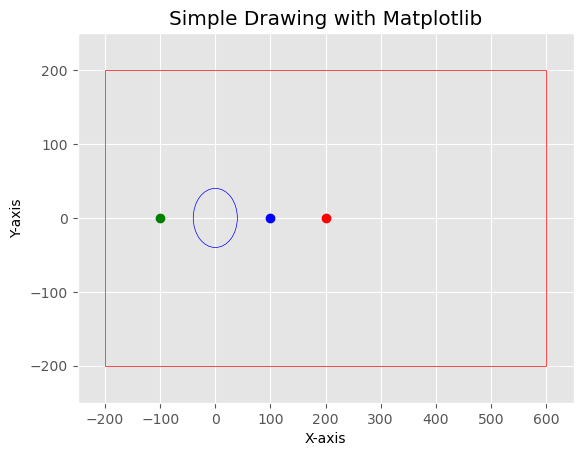

In [11]:
import matplotlib.pyplot as plt

# Create a figure and an axes
fig, ax = plt.subplots()

# Draw a circle centered at the origin with radius 4
circle = plt.Circle((0, 0), 40, color='blue', fill=False)
ax.add_artist(circle)

# Draw a rectangle from -200 to 600 in x direction and -200 to 200 in y direction
rectangle = plt.Rectangle((-200, -200), 800, 400, color='red', fill=False)
ax.add_artist(rectangle)

# Plot a point at (200, 0)
ax.plot(-100, 0, 'go') # 'go' for green color and circle marker
ax.plot(100, 0, 'bo') # 'go' for green color and circle marker
ax.plot(200, 0, 'ro') # 'go' for green color and circle marker

# Set the x and y axis limits to visualize the rectangle boundaries and the circle
ax.set_xlim(-250, 650)
ax.set_ylim(-250, 250)

# Add grid, labels, and title for clarity
ax.grid(True)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Simple Drawing with Matplotlib')

# Show the plot
plt.show()


In [12]:
location = [[-100,0],[100,0],[200,0]]
paths = ['emh.csv', 'nemh.csv', 'nmh.csv', 'nwmh.csv', 'wmh.csv', 'swmh.csv', 'smh.csv', 'semh.csv']
theta = [0, 45, 90, 135, 180, 225, 270, 315]
file_path='wmhC'
wmh_c = read_data_file(file_path)
signal = np.zeros([len(paths)*(len(location)+1),100])
for i, path in enumerate(paths):
    if i != 4:
        data = load_csv(path)
    signal[4*i+3] = theta[i]
    for j, loc in enumerate(location):        
        index = find_index(*loc) #16922 16936 16955
        if i==4:
            signal[4*i+j] = wmh_c[:, index]
        else:
            signal[4*i+j] = data['c'][np.arange(len(data['c'])) % 22341 == index][:100]

In [13]:
DF = pd.DataFrame(np.transpose(signal))
csv_file = DF.to_csv('nemh_signals_mh.csv')

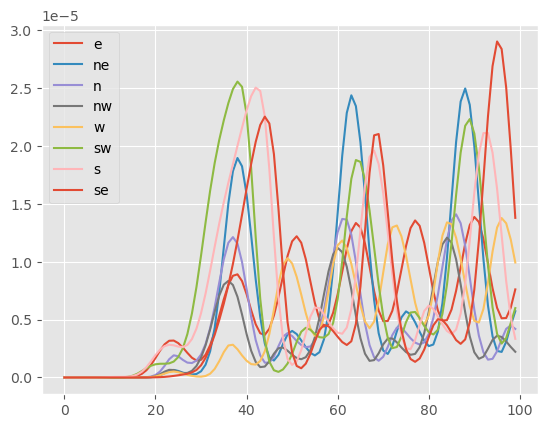

In [14]:

for NN in range(8):
    if NN == 2:
        C = 0.01
    elif NN == 4:
    #    C = 0
        C = 1
    else:
        C = 1
    upwind = C*signal[4*NN+0,:]
    downwind_close = C*signal[4*NN+1,:]
    downwind_far = C*signal[4*NN+2,:]
    #plt.plot(upwind, label='upwind') #0
    #plt.plot(downwind_close, label=paths[NN][:-6]) #1
    plt.plot(downwind_far, label=paths[NN][:-6]) #2
    plt.title('')

plt.legend()

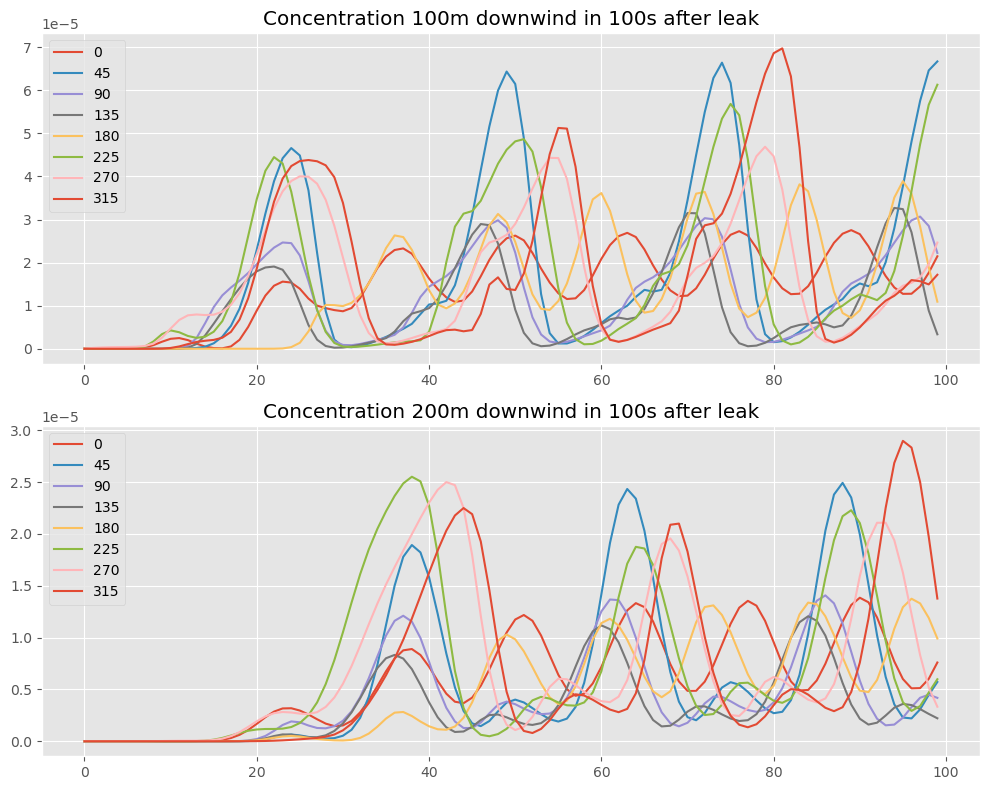

In [15]:
plt.figure(figsize=(10, 8))

for NN in range(8):
    if NN == 2:
        C = 0.01
    else:
        C = 1
    upwind = signal[4*NN+0,:]
    downwind_close = signal[4*NN+1,:]
    downwind_far = signal[4*NN+2,:]

    plt.subplot(2, 1, 1) # 2 rows, 1 column, index 1 (top)
    #plt.plot(upwind * C, label=theta[NN])
    plt.plot(downwind_close * C, label=theta[NN])
    plt.title('Concentration 100m downwind in 100s after leak')
    plt.legend(loc='upper left')

    plt.subplot(2, 1, 2) # 2 rows, 1 column, index 2 (bottom)
    plt.plot(downwind_far * C, label=theta[NN])
    plt.title('Concentration 200m downwind in 100s after leak')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

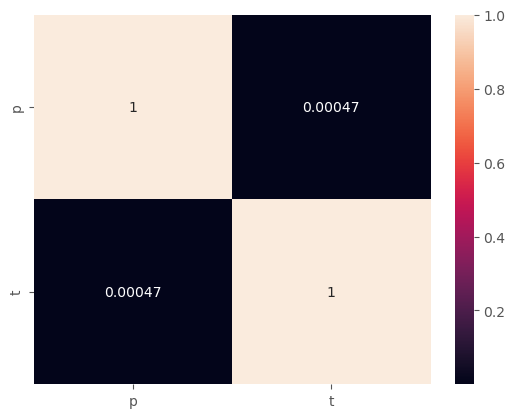

In [16]:
plt_var = ['p', 't']
subset_df = data_n[plt_var]
corelation = subset_df.corr()
sns.heatmap(corelation,xticklabels=corelation.columns, yticklabels=corelation.columns, annot=True)
plt.show()


<Axes: xlabel='t', ylabel='p'>

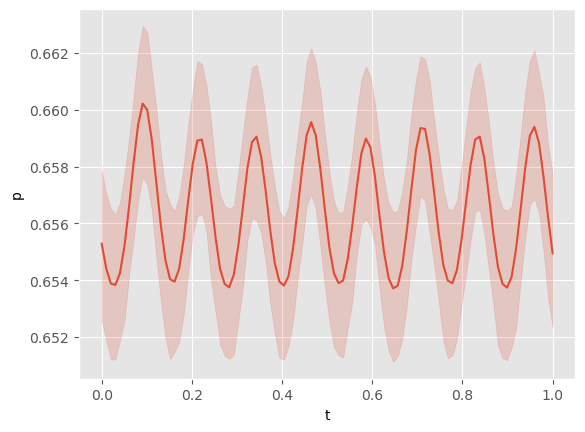

In [17]:
sns.lineplot(x="t",y="p", data=data_n)
#sns.lineplot(x="p",y="t",data=data_n)
#plt.show


C:\Users\Mehrdad\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Mehrdad\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='log_v', ylabel='log_w'>

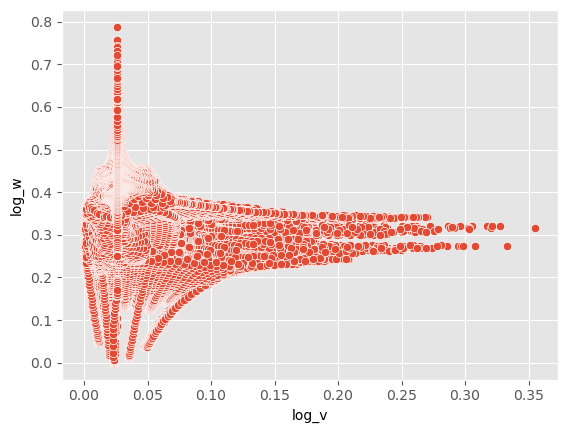

In [18]:
log_base =0.000000000002
data_n['log_v'] = np.log(data_n['v']) / np.log(log_base)
data_n['log_w'] = np.log(data_n['w']) / np.log(log_base)
sns.scatterplot(data=data_n, x='log_v', y='log_w')


In [19]:
def plot_variable_evolution(df, index, variable_y='c',variable_x='t'):
    # Check if the index is within the valid range
    if not (0 <= index < 22341):
        raise ValueError("Index must be between 0 and 22340")

    # Extracting the variable data for the specific point across all snapshots
    variable_data_x = df[variable_y].iloc[index::22341].astype(np.float32)
    variable_data_y = df[variable_x].iloc[index::22341].astype(np.float32)
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(variable_data_y, variable_data_x)
    plt.xlabel(variable_x)
    plt.ylabel(variable_y)
    plt.title(f'Evolution of {variable_y} over time at data point {index}')
    plt.grid(True)
    plt.show()

In [20]:
def plot_contour(df, snapshot_number, x_sensor, y_sensor, variable_y='c',variable_x='t'):
    # Check if the snapshot number is valid each snapshot represent snapshot-1 t=1sec snapshot t =2 sec there are 20k data points for each snapshot
    if not (1 <= snapshot_number <= 100):
        raise ValueError("Snapshot number must be between 1 and 100")

    # Calculate the row range for the selected snapshot
    start_row = (snapshot_number - 1) * 22341
    end_row = start_row + 22341

    # Extract the snapshot data
    snapshot_data = df.iloc[start_row:end_row]

    # Extract x, y, and c values
    x = snapshot_data['x'].astype(np.float64)
    y = snapshot_data['y'].astype(np.float64)
    c = snapshot_data[variable_y].astype(np.float64)
    c = np.log10(c + 0.0000001)
    # Create a Triangulation
    triang = tri.Triangulation(x, y)

    # Plotting the contour
    fig, ax = plt.subplots(figsize=(10, 8))
    
    #levels = np.linspace(max(c.min(), -16), c.max(), 50)
    levels = np.arange(-7, -1, 0.2)
    contour_plot = ax.tricontourf(triang,c, levels=levels, cmap='viridis')
    # Adding a solid circle to mask the contour
    circle_radius=40
    circle = plt.Circle((0, 0), circle_radius, color='white', zorder=10)
    ax.add_artist(circle)

    # plot sensor location as an x on the contour
    ax.plot(x_sensor, y_sensor,marker='o', color='red', markersize=8)  # Plotting sensor location
    ax.plot(200, y_sensor,marker='o', color='blue', markersize=8)  # Plotting sensor location
    ax.set_aspect('equal', 'box')
    ax.set_title(f'Contour at 40s After Leak', fontsize=16)
    ax.set_xlabel('meters', fontsize=12)
    ax.grid(True)
    # Create a new Axes for the colorbar
    cbar_ax = fig.add_axes([0.93, 0.25, 0.03, 0.5])  # Adjust these values as needed
    cbar = fig.colorbar(contour_plot, cax=cbar_ax)
    #cbar.set_label(variable)
    cbar.set_label('Log(concentration)', fontsize=14)
    
    # Set y-axis ticks
    ymin, ymax = ax.get_ylim()  # Get the current y-axis limits
    ax.set_yticks(np.arange(ymin, ymax + 100, 100))
    

    
    plt.show()

# Example usage
path = 'nmh.csv'
data = load_csv(path)

#plot_contour(data, 100, 100, 0, 'c')


In [21]:
# Get the x and y from the csv file to use in Ansys Ensight as candidate sensor locations
df_subset = data.loc[:22340, ['x', 'y']]
df_subset['zero'] = 0.0
# Export the subset to a CSV file
df_subset.to_csv('points__.csv', index=False)

In [22]:
data.iloc[15000]['x']

487.248322

In [23]:
data.iloc[15000]['y']

-81.0810776

## Generate grid_points.txt for Ansys Insight

In [24]:
def distance_from_origin(x, y, z=0):
    return math.sqrt(x ** 2 + y ** 2 + z ** 2)

# Initialize the file
with open("grid_points.txt", "w") as f:
    # Write headers
    f.write("#Version 1.0\n")
    f.write("#EnSight Point Format\n")

    # Loop over the grid range
    for x in range(-200, 600, 5):  # x goes from -200 to 200 with step size 4
        for y in range(-200, 200, 5):  # y goes from -200 to 200 with step size 4
            z = 0  # z is always 0

            # Check if the point is at an acceptable distance from the origin
            if distance_from_origin(x, y, z) >= 40:
                # Write the point to the file
                f.write(f"{x}, {y}, {z}\n")

NameError: name 'math' is not defined

## Read the Coordinates of the sensor locations

In [ ]:
x_coords = []
y_coords = []

with open("grid_points.txt", "r") as f:
    reader = csv.reader(f)
    headers = [next(reader) for _ in range(2)]  # Skip the first two header lines

    for row in reader:
        x, y, z = map(float, row)
        x_coords.append(x)
        y_coords.append(y)

In [ ]:
### Plot the points
plt.figure(figsize=(7,4))
plt.plot(x_sensor,y_sensor, 's', markersize=9)
plt.axis('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Grid Points")
plt.show()
print(len(x_sensor))